In [9]:
import os

import librosa
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from doepy import build
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
from tqdm.auto import tqdm

from modelisation_physique.mvt_Helmholtz import simulation
# from modal_leo import run_simulation

In [10]:
%matplotlib widget

Utilitary functions

In [11]:
def are_there_oscillations(waveform, epsilon):
    N2_3 = int(len(waveform) / 3)
    criterion = np.mean(np.abs(waveform[N2_3:]))
    return criterion > epsilon


def get_f0(waveform, sr, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("C7")):
    """ Estimate F0 using Yin's algorithm. The algorithm is applied frame by frame
    then the final F0 is obtained using the mean of the last 2/3 frames."""
    n_1_3 = int(np.rint(len(waveform) / 3))
    f0 = librosa.yin(waveform[n_1_3:], fmin=fmin, fmax=fmax, sr=sr)
    return np.mean(f0[1:])


def f0_to_categorical(f0, ref_frequencies, epsilon):
    """ This function checks whether f0 is close to a frequency in the ref_frequencies
    array, close meaning less than epsilon cents away.

    Args:
        f0 (float): f0 to test
        ref_frequencies (array): Array of reference frequencies to be checked
        epsilon (int): Theshold in cents
    """
    n_cents = np.abs(1200 * np.log(f0 / ref_frequencies))
    idx = np.argmin(n_cents)
    if n_cents[idx] > epsilon:
        return False, None
    else:
        return True, idx

Simulation parameters

In [24]:
sim_length = 0.3
sample_rate = 22050
num_samples = 1000
celerity = 340
osc_threshold = 0.15  # threshold to decide whether there are oscillations or not
cents_threshold = 15
l2_penalty = 1e6  # L2 Penalty for the SVM optimization
epsilon_length = 0.05  # meters

# Full octave from C0 to B0
note_frequencies = [65.41, 69.3, 73.42, 77.78, 82.41, 87.31, 92.5, 98, 103.83, 110, 116.54, 123.47]

# note_frequencies = [65.41, 69.3, 73.42]

length_min = celerity / (4 * note_frequencies[-1]) - epsilon_length
length_max = celerity / (4 * note_frequencies[0]) + epsilon_length

print(f"The length of the cylinder goes from {length_min} to {length_max}")

The length of the cylinder goes from 0.6384263383817931 to 1.3494954899862408


Initial DOE

In [25]:
zeta = 0.5
parameters = build.space_filling_lhs(
    {"gamma": [0, 1], 
     "length_cylinder": [length_min, length_max]},
    num_samples=num_samples
)

In [26]:
n_classes = len(note_frequencies)
labels = np.zeros(num_samples)
mean_amplitude = np.zeros(num_samples)

for i, x in tqdm(parameters.iterrows()):
    waveform, _ = simulation(sim_length, sample_rate, x["gamma"], zeta, x["length_cylinder"], celerity)
    f0 = get_f0(waveform, sample_rate) * are_there_oscillations(waveform, osc_threshold)
    is_close, idx = f0_to_categorical(f0, note_frequencies, epsilon=cents_threshold)
    if is_close:
        labels[i] = idx
    else:
        labels[i] = n_classes
    
X, y = parameters.to_numpy(), labels 

0it [00:00, ?it/s]

/tmp/ipykernel_7376/324317865.py:24: RuntimeWarning: divide by zero encountered in log
  n_cents = np.abs(1200 * np.log(f0 / ref_frequencies))


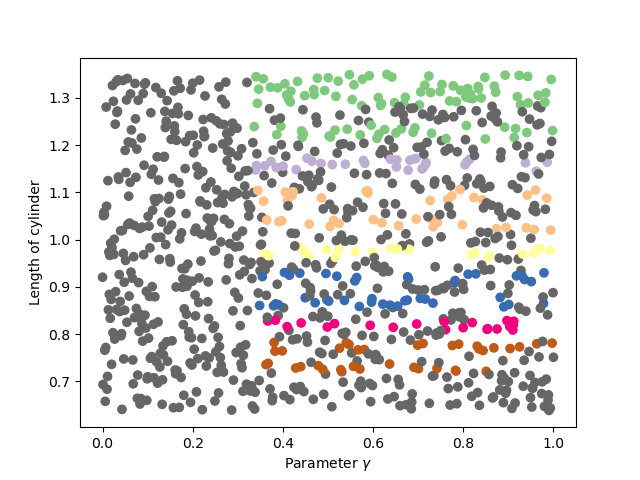

In [27]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Accent)
plt.xlabel(r"Parameter $\gamma$")
plt.ylabel("Length of cylinder")
plt.show()

In [28]:
model = SVC(C=l2_penalty, random_state=42, class_weight="balanced").fit(X, y)

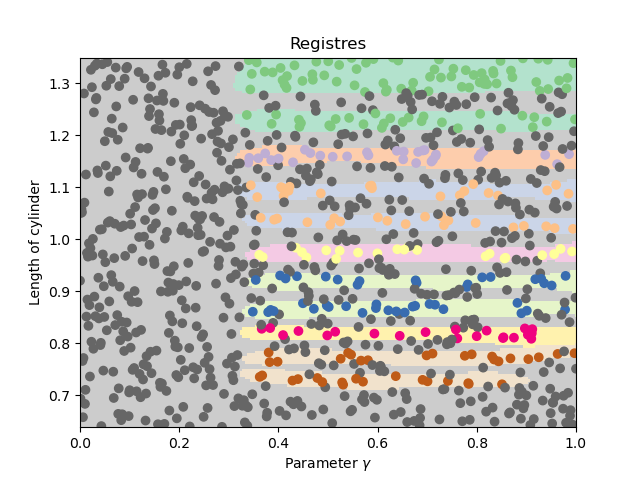

In [29]:
plt.figure()
mesh_step_size = 0.005

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.Accent)
plt.title("Registres")
plt.xlabel(r"Parameter $\gamma$")
plt.ylabel("Length of cylinder")
plt.xlim([0, 1])
plt.ylim([length_min, length_max])
plt.show()